# 🤟 ASL (American Sign Language) 알파벳 분류기

이 노트북은 **Convolutional Neural Network (CNN)**을 사용하여 수화 알파벳(A-Z) 이미지를 분류하는 딥러닝 모델을 구현합니다.
PyTorch 프레임워크를 기반으로 데이터 로드, 전처리, 모델 학습, 그리고 평가까지의 전체 파이프라인을 다룹니다.

### 주요 기능
- **데이터셋**: Sign Language MNIST (CSV) 또는 이미지 폴더 구조 지원
- **모델**: 2개의 컨볼루션 레이어(Conv2d)와 완전 연결 레이어(Linear)로 구성된 CNN
- **학습**: CrossEntropyLoss 및 Adam 옵티마이저 사용
- **평가**: 정확도(Accuracy) 및 혼동 행렬(Confusion Matrix) 시각화


## 빠른 실행 가이드

1. **데이터 준비**: `./data/asl_data` 폴더에 데이터셋이 있는지 확인하세요. (없다면 아래 다운로드 셀 실행)
2. **순차 실행**: 상단 메뉴의 `Run All`을 클릭하거나, 셀을 위에서부터 차례대로 실행하세요.
3. **결과 확인**: 학습 진행 상황 그래프와 테스트 세트에 대한 최종 예측 결과를 확인하세요.


## 0. 데이터셋 준비

실제 ASL 데이터셋이 필요합니다. 아래 코드는 로컬 경로를 확인하거나 다운로드 방법을 안내합니다.

> **참고**: Kaggle의 [Sign Language MNIST](https://www.kaggle.com/datamush/sign-language-mnist) 데이터셋을 추천합니다.


In [86]:
import os
import zipfile
import shutil
import requests
from pathlib import Path

def download_asl_dataset(target_dir="./data/asl_data"):
    target_path = Path(target_dir)
    if target_path.exists() and any(target_path.iterdir()):
        print(f"✅ 데이터셋이 이미 존재합니다: {target_path}")
        return
    
    print("⚠️ 데이터셋 다운로드 기능은 현재 구현되어 있지 않습니다.")
    print(f"    '{target_path}' 폴더에 'sign_mnist_train.csv'와 'sign_mnist_valid.csv'를 넣어주세요.")
    # 실제 다운로드 로직 구현 가능 (예: kaggle API 사용 등)

download_asl_dataset()

✅ 데이터셋이 이미 존재합니다: data\asl_data


## 1. 라이브러리 임포트

딥러닝 모델링에 필요한 `torch`, 데이터 처리를 위한 `numpy`, `pandas`, 그리고 시각화를 위한 `matplotlib` 등을 불러옵니다.


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import cv2
import pandas as pd
from torchvision import transforms
import matplotlib as mpl
import matplotlib.font_manager as fm

def set_korean_font():
    for font_name in ["Malgun Gothic", "NanumGothic", "AppleGothic", "D2Coding"]:
        try:
            fm.findfont(font_name, fallback_to_default=False)
            mpl.rcParams["font.family"] = font_name
            mpl.rcParams["axes.unicode_minus"] = False
            return font_name
        except Exception:
            continue
    mpl.rcParams["axes.unicode_minus"] = False
    return None

FONT_USED = set_korean_font()
if FONT_USED:
    print(f"한글 폰트 적용: {FONT_USED}")
else:
    print("한글 폰트를 찾지 못해 기본 폰트로 표시합니다.")

한글 폰트 적용: Malgun Gothic


## 2. CNN 모델 아키텍처 정의

이미지의 공간적 특징을 효과적으로 추출하기 위해 **CNN (Convolutional Neural Network)**을 사용합니다.

- **Feature Extractor**: 2개의 Conv2d 레이어 (ReLU 활성화 함수, MaxPool2d 포함)
- **Classifier**: Flatten 후 2개의 Linear 레이어 (Dropout 포함)


In [88]:
class ASL_CNN_Classifier(nn.Module):
    def __init__(self, num_classes=26):
        super(ASL_CNN_Classifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layers
        # 입력 이미지 크기가 28x28이라고 가정
        # conv1 -> 28x28x32 -> pool -> 14x14x32
        # conv2 -> 14x14x64 -> pool -> 7x7x64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 3. 커스텀 데이터셋 클래스 (`ASLDataset`)

`torch.utils.data.Dataset`을 상속받아 ASL 데이터셋을 로드하고 전처리하는 클래스를 정의합니다.

- **지원 포맷**: CSV 파일 (`sign_mnist_train.csv`) 또는 폴더 구조 (`A/`, `B/`, ...)
- **기능**: 이미지 로드, 그레이스케일 변환, 정규화, 텐서 변환


In [89]:
class ASLDataset(Dataset):
    """ASL 데이터셋 클래스 (sign_mnist CSV 또는 A-Z 폴더)"""

    def __init__(self, data_dir=None, image_size=(28, 28), is_train=True, transform=None, images=None, labels=None):
        """
        Args:
            data_dir: 실제 ASL 데이터셋 경로 (선택)
            image_size: 이미지 크기 (H, W)
            is_train: train/test 선택
            transform: 이미지에 적용할 transform
            images: 미리 로드된 이미지 데이터 (numpy array)
            labels: 미리 로드된 라벨 데이터 (numpy array)
        """
        self.image_size = image_size
        self.num_classes = 26  # A-Z
        self.is_train = is_train
        self.transform = transform

        self.images = np.array([])
        self.labels = np.array([])

        # 1. 직접 데이터가 전달된 경우 (우선순위 높음)
        if images is not None and labels is not None:
            self.images = images
            self.labels = labels
        
        # 2. 데이터 경로가 제공된 경우 로드 시도
        elif data_dir and os.path.exists(data_dir):
            self.images, self.labels = self._load_real_data(data_dir)
        
        # 3. 데이터가 없는 경우 에러 발생
        if len(self.images) == 0:
            raise ValueError(f"데이터를 로드할 수 없습니다. '{data_dir}' 경로를 확인하거나 올바른 데이터를 제공해주세요.")

    def _load_real_data(self, data_dir):
        """실제 데이터 로드 (CSV 또는 폴더)"""
        images = []
        labels = []
        
        # 1. CSV 파일 확인 (여러 파일명 시도)
        # is_train=True: sign_mnist_train.csv
        # is_train=False: sign_mnist_test.csv 또는 sign_mnist_valid.csv
        csv_candidates = []
        if self.is_train:
            csv_candidates = ["sign_mnist_train.csv"]
        else:
            csv_candidates = ["sign_mnist_test.csv", "sign_mnist_valid.csv"]
        
        for csv_filename in csv_candidates:
            csv_path = os.path.join(data_dir, csv_filename)
            if os.path.exists(csv_path):
                print(f"CSV 파일 로드 중: {csv_path}")
                try:
                    df = pd.read_csv(csv_path)
                    labels = df.iloc[:, 0].values
                    images = df.iloc[:, 1:].values
                    images = images.reshape(-1, 28, 28).astype(np.float32) / 255.0
                    print(f"로드 완료: {len(images)}개 이미지")
                    return images, labels
                except Exception as e:
                    print(f"CSV 로드 실패 ({csv_filename}): {e}")
                    continue
            
        # 2. 폴더 구조 확인 (A-Z)
        base_path = Path(data_dir)
        class_folders = []
        for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
            letter_path = base_path / letter
            if letter_path.exists() and letter_path.is_dir():
                class_folders.append((letter, letter_path))

        if not class_folders:
             return np.array([]), np.array([])

        for label_idx, (_, folder_path) in enumerate(class_folders):
            image_files = (
                list(folder_path.glob("*.jpg"))
                + list(folder_path.glob("*.png"))
                + list(folder_path.glob("*.jpeg"))
            )

            for img_file in image_files:
                try:
                    # 한글 경로 지원을 위해 numpy fromfile 사용
                    img_array = np.fromfile(str(img_file), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue
                    if img.shape != self.image_size:
                        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
                    img = img.astype(np.float32) / 255.0
                    images.append(img)
                    labels.append(label_idx)
                except Exception:
                    continue

        if len(images) == 0:
             return np.array([]), np.array([])

        print(f"로드된 이미지: {len(images)}개, 클래스 수: {len(class_folders)}개")
        return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx >= len(self.images):
            raise IndexError(f"Index {idx} out of bounds for dataset with size {len(self.images)}")
            
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).float().unsqueeze(0)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


In [90]:
test_data = ASLDataset(data_dir=ASL_DATA_DIR, image_size=IMAGE_SIZE, is_train=False)
test_data.__getitem__(0)

CSV 파일 로드 중: ./data/asl_data\sign_mnist_valid.csv
로드 완료: 7172개 이미지


(tensor([[[0.5843, 0.5843, 0.5882, 0.5882, 0.5882, 0.5922, 0.5922, 0.5882,
           0.5922, 0.5961, 0.5961, 0.5961, 0.5961, 0.5961, 0.6000, 0.6000,
           0.5922, 0.5961, 0.5961, 0.6000, 0.5961, 0.5961, 0.5922, 0.5922,
           0.5882, 0.5882, 0.5882, 0.5843],
          [0.5882, 0.5882, 0.5882, 0.5961, 0.5961, 0.5922, 0.5961, 0.5961,
           0.5961, 0.5961, 0.5961, 0.6000, 0.6039, 0.6000, 0.6039, 0.6039,
           0.6000, 0.6039, 0.6000, 0.6039, 0.6000, 0.6000, 0.5961, 0.5961,
           0.5961, 0.5922, 0.5882, 0.5922],
          [0.5882, 0.5922, 0.5922, 0.5961, 0.5961, 0.5961, 0.6000, 0.6000,
           0.5961, 0.5961, 0.5961, 0.6000, 0.6039, 0.6039, 0.6078, 0.6078,
           0.6039, 0.6039, 0.6078, 0.6078, 0.6078, 0.6078, 0.6039, 0.6000,
           0.6000, 0.5922, 0.5922, 0.5961],
          [0.5882, 0.5922, 0.5922, 0.5961, 0.5961, 0.5961, 0.6039, 0.6039,
           0.6039, 0.6039, 0.6039, 0.6000, 0.6039, 0.6078, 0.6118, 0.6157,
           0.6157, 0.6118, 0.6078, 0.6118, 

In [91]:
# 하이퍼파라미터 설정
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
NUM_CLASSES = 26
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"사용 디바이스: {DEVICE}")

# 데이터 전처리 (Augmentation)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# 데이터 로드 및 분할 (Train 70% / Valid 20% / Test 10%)
data_dir = "./data/asl_data"
full_images = []
full_labels = []

# 1. CSV 파일 로드 시도
train_csv = os.path.join(data_dir, "sign_mnist_train.csv")
test_csv = os.path.join(data_dir, "sign_mnist_test.csv")

if os.path.exists(train_csv):
    print("CSV 파일에서 데이터 로드 중...")
    df_train = pd.read_csv(train_csv)
    df_test = pd.read_csv(test_csv) if os.path.exists(test_csv) else pd.DataFrame()
    
    # 병합
    df_full = pd.concat([df_train, df_test], ignore_index=True)
    full_labels = df_full.iloc[:, 0].values
    full_images = df_full.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.float32) / 255.0
else:
    # 폴더 구조 로드 시도 (임시 인스턴스 사용)
    print("폴더에서 데이터 로드 시도 중...")
    temp_dataset = ASLDataset(data_dir=data_dir, is_train=True)
    if len(temp_dataset) > 0:
        full_images = temp_dataset.images
        full_labels = temp_dataset.labels

# 데이터가 있으면 분할 수행
if len(full_images) > 0:
    total_size = len(full_images)
    indices = np.arange(total_size)
    np.random.seed(42)
    np.random.shuffle(indices)

    train_split = int(total_size * 0.7)
    valid_split = int(total_size * 0.9)  # 70% + 20% = 90%

    train_indices = indices[:train_split]
    valid_indices = indices[train_split:valid_split]
    test_indices = indices[valid_split:]

    train_dataset = ASLDataset(images=full_images[train_indices], labels=full_labels[train_indices], transform=train_transform)
    valid_dataset = ASLDataset(images=full_images[valid_indices], labels=full_labels[valid_indices], transform=test_transform)
    test_dataset = ASLDataset(images=full_images[test_indices], labels=full_labels[test_indices], transform=test_transform)

    print(f"전체 데이터: {total_size}개")
    print(f"학습(Train): {len(train_dataset)}개 (70%)")
    print(f"검증(Valid): {len(valid_dataset)}개 (20%)")
    print(f"테스트(Test): {len(test_dataset)}개 (10%)")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
else:
    print("데이터를 찾지 못해 더미 데이터로 초기화합니다.")
    train_dataset = ASLDataset(is_train=True, transform=train_transform)
    valid_dataset = ASLDataset(is_train=False, transform=test_transform)
    test_dataset = ASLDataset(is_train=False, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

사용 디바이스: cuda
CSV 파일에서 데이터 로드 중...
전체 데이터: 27455개
학습(Train): 19218개 (70%)
검증(Valid): 5491개 (20%)
테스트(Test): 2746개 (10%)


### 3-1. 학습 데이터 미리보기 (DataFrame)

학습 데이터셋(`train_dataset`)의 일부를 Pandas DataFrame 형태로 변환하여 확인합니다.
이미지 데이터는 픽셀 값(0~1)으로 정규화되어 있으며, 라벨은 0~25 사이의 정수입니다.


In [92]:
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,12,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,22,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,17,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,16,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


## 4. 데이터 분포 확인

학습 데이터와 테스트 데이터의 클래스별(A-Z) 분포를 시각화하여 데이터 불균형 문제가 있는지 확인합니다.


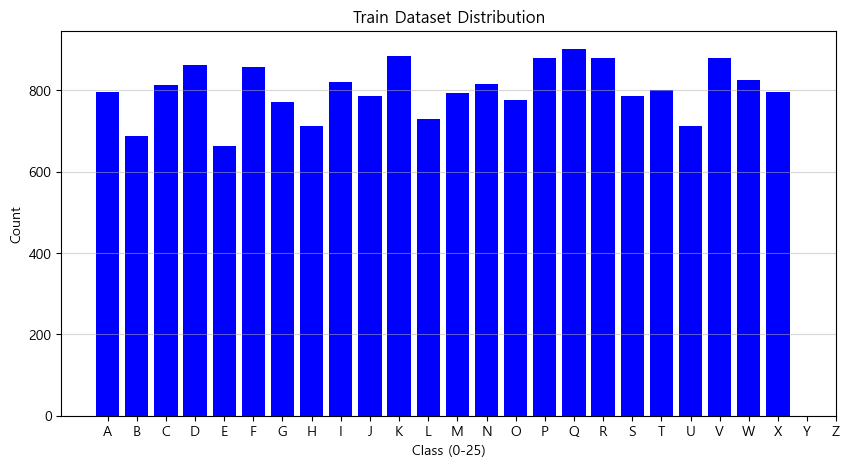

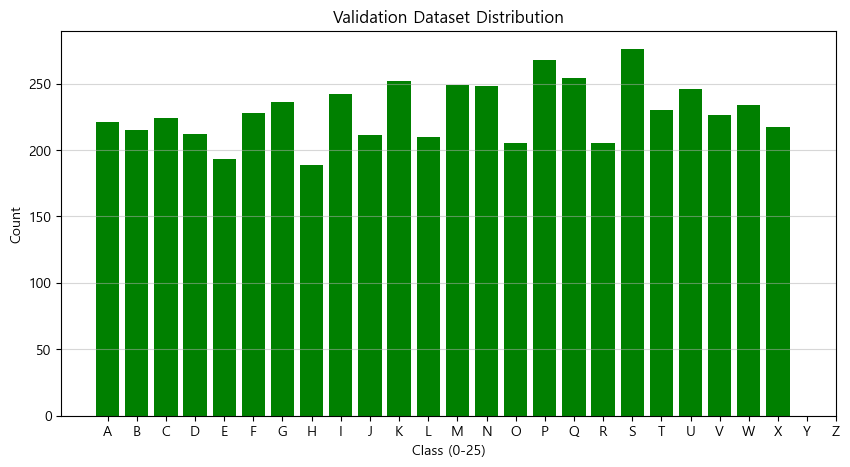

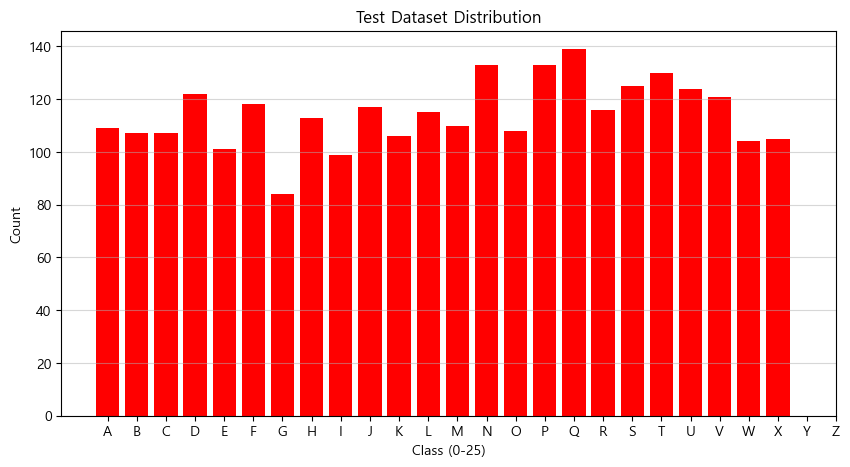

In [93]:
def plot_dataset_distribution(dataset, title="Dataset Distribution", color='blue'):
    if len(dataset) == 0:
        return
    
    labels = dataset.labels
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts, color=color)
    plt.title(title)
    plt.xlabel("Class (0-25)")
    plt.ylabel("Count")
    plt.xticks(range(26), [chr(i+65) for i in range(26)])
    plt.grid(axis='y', alpha=0.5)
    plt.show()

plot_dataset_distribution(train_dataset, "Train Dataset Distribution", color='blue')
plot_dataset_distribution(valid_dataset, "Validation Dataset Distribution", color='green')
plot_dataset_distribution(test_dataset, "Test Dataset Distribution", color='red')

## 5. 모델 및 학습 객체 초기화

- **Model**: `ASL_CNN_Classifier` 인스턴스 생성 (GPU 사용 가능 시 자동 할당)
- **Loss Function**: 다중 분류를 위한 `CrossEntropyLoss`
- **Optimizer**: `Adam` (Learning Rate: 0.001)


In [94]:
model = ASL_CNN_Classifier(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

ASL_CNN_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


## 6. 모델 학습 (Training Loop)

지정된 Epoch 만큼 학습을 진행하며, 매 Epoch마다 학습(Train) 및 검증(Validation) 손실과 정확도를 기록합니다.


In [95]:
# 모델 저장 디렉토리 생성
os.makedirs('./model', exist_ok=True)

# 학습/검증 반복: 에포크마다 손실·정확도 저장
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 최고 성능 추적을 위한 변수
best_val_acc = 0.0
best_epoch = 0

for epoch_idx in range(NUM_EPOCHS):
    # 학습 단계
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_acc = val_correct / val_total
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch [{epoch_idx+1}/{NUM_EPOCHS}]\n")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
    
    # 최고 성능 모델 저장
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        best_epoch = epoch_idx + 1
        
        # 모델 저장
        model_save_path = './model/best_asl_model.pth'
        torch.save({
            'epoch': epoch_idx + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'train_acc': avg_train_acc,
            'val_loss': avg_val_loss,
            'val_acc': avg_val_acc,
        }, model_save_path)
        
        print(f"  ✓ 최고 성능 모델 저장! (Val Acc: {avg_val_acc:.4f})")
    
    print("-" * 50)

print(f"\n학습 완료!")
print(f"최고 검증 정확도: {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"모델 저장 경로: ./model/best_asl_model.pth")

Epoch [1/20]

  Train Loss: 1.9508 | Train Acc: 0.3956
  Val Loss: 0.6867 | Val Acc: 0.8009
  ✓ 최고 성능 모델 저장! (Val Acc: 0.8009)
--------------------------------------------------
Epoch [2/20]

  Train Loss: 0.8281 | Train Acc: 0.7276
  Val Loss: 0.3120 | Val Acc: 0.9100
  ✓ 최고 성능 모델 저장! (Val Acc: 0.9100)
--------------------------------------------------
Epoch [3/20]

  Train Loss: 0.5360 | Train Acc: 0.8169
  Val Loss: 0.1363 | Val Acc: 0.9685
  ✓ 최고 성능 모델 저장! (Val Acc: 0.9685)
--------------------------------------------------
Epoch [4/20]

  Train Loss: 0.4029 | Train Acc: 0.8630
  Val Loss: 0.0959 | Val Acc: 0.9876
  ✓ 최고 성능 모델 저장! (Val Acc: 0.9876)
--------------------------------------------------
Epoch [5/20]

  Train Loss: 0.3142 | Train Acc: 0.8947
  Val Loss: 0.0594 | Val Acc: 0.9907
  ✓ 최고 성능 모델 저장! (Val Acc: 0.9907)
--------------------------------------------------
Epoch [6/20]

  Train Loss: 0.2682 | Train Acc: 0.9125
  Val Loss: 0.0435 | Val Acc: 0.9924
  ✓ 최고 성능 모델 저장! (

## 7. 학습 결과 시각화

학습 과정에서의 **Loss(손실)** 감소와 **Accuracy(정확도)** 증가 추이를 그래프로 확인합니다.


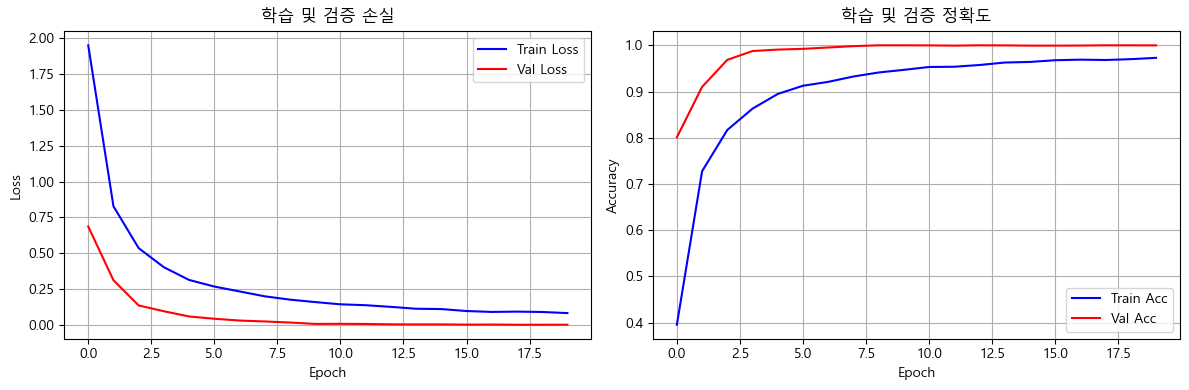


최종 검증 정확도: 0.9998


In [96]:
needed = ["train_losses", "val_losses", "train_accuracies", "val_accuracies"]
missing = [name for name in needed if name not in globals()]
if missing:
    print("학습 데이터가 없습니다. 먼저 학습 셀을 실행해주세요.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 손실 곡선
    axes[0].plot(train_losses, label="Train Loss", color="blue")
    axes[0].plot(val_losses, label="Val Loss", color="red")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("학습 및 검증 손실")
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 곡선
    axes[1].plot(train_accuracies, label="Train Acc", color="blue")
    axes[1].plot(val_accuracies, label="Val Acc", color="red")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("학습 및 검증 정확도")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n최종 검증 정확도: {val_accuracies[-1]:.4f}")

### 7-1. 혼동 행렬 (Confusion Matrix)

테스트 세트에 대한 모델의 예측 성능을 클래스별로 세부적으로 분석합니다.
어떤 알파벳을 서로 헷갈려하는지 파악할 수 있습니다.


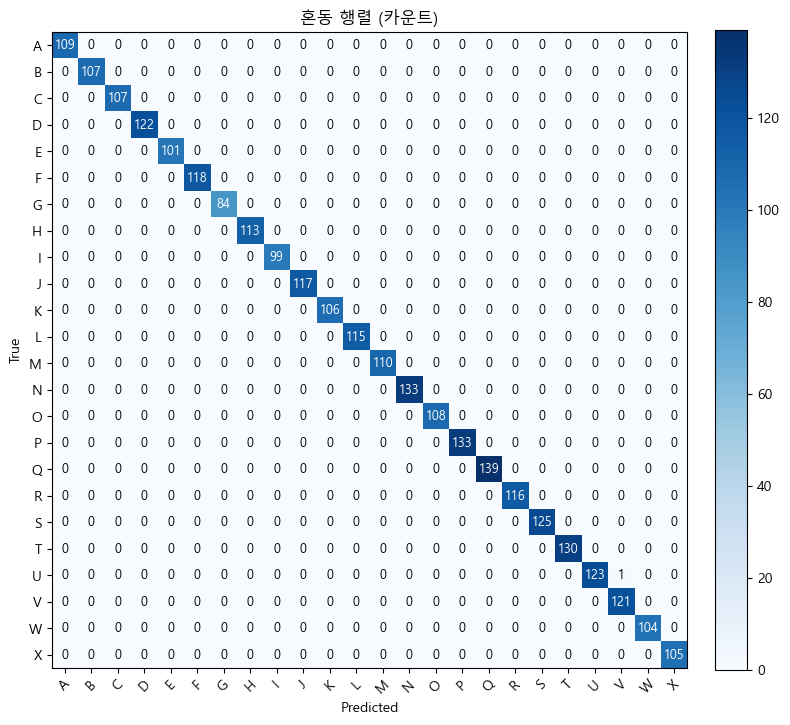

In [97]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

if len(all_preds) > 0:
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    present_labels = sorted(set(all_labels.tolist()) | set(all_preds.tolist()))
    label_to_pos = {lab: idx for idx, lab in enumerate(present_labels)}
    n_cls = len(present_labels)
    cm = np.zeros((n_cls, n_cls), dtype=int)

    for t, p in zip(all_labels, all_preds):
        cm[label_to_pos[t], label_to_pos[p]] += 1

    class_labels = [chr(ord("A") + i) for i in present_labels]
    max_count = max(1, cm.max())

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=max_count)
    ax.set_title("혼동 행렬 (카운트)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(n_cls))
    ax.set_yticks(range(n_cls))
    ax.set_xticklabels(class_labels, rotation=45)
    ax.set_yticklabels(class_labels)

    for (i, j), val in np.ndenumerate(cm):
        text_color = "white" if val > max_count * 0.6 else "black"
        ax.text(j, i, str(val), ha="center", va="center", fontsize=9, color=text_color)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("테스트 데이터가 없어 혼동 행렬을 그릴 수 없습니다.")

In [101]:
# 저장된 모델 불러오기
loaded_model = ASL_CNN_Classifier(num_classes=NUM_CLASSES).to(DEVICE)
checkpoint = torch.load('./model/best_asl_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()  # 평가 모드로 설정

print(f"Epoch {checkpoint['epoch']}의 모델 로드 완료")
print(f"검증 정확도: {checkpoint['val_acc']:.4f}")

Epoch 9의 모델 로드 완료
검증 정확도: 1.0000


## 8. 실전 테스트 (Inference)

테스트 데이터셋에서 무작위로 이미지를 선택하여 모델이 올바르게 예측하는지 시각적으로 확인합니다.


✓ Epoch 9의 모델 로드 완료
  검증 정확도: 1.0000

테스트 데이터셋(Test Dataset)에서 무작위 샘플을 예측합니다.


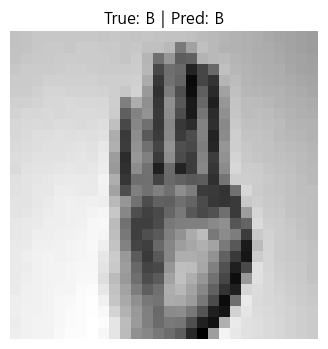

In [102]:
class_names = [chr(i + 65) for i in range(26)]  # A-Z

def predict_random_sample(dataset, model, device, classes):
    """테스트 데이터셋에서 무작위 샘플을 뽑아 예측"""
    if len(dataset) == 0:
        print("데이터셋이 비어있습니다.")
        return

    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]
    
    # 모델 예측
    model.eval()
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        
    # 시각화
    plt.figure(figsize=(4, 4))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {classes[label]} | Pred: {classes[predicted.item()]}")
    plt.axis('off')
    plt.show()

# 저장된 모델 불러오기
try:
    loaded_model = ASL_CNN_Classifier(num_classes=NUM_CLASSES).to(DEVICE)
    checkpoint = torch.load('./model/best_asl_model.pth')
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    print(f"✓ Epoch {checkpoint['epoch']}의 모델 로드 완료")
    print(f"  검증 정확도: {checkpoint['val_acc']:.4f}")
    print()
    
    # 테스트 데이터셋에서 예측 수행
    if 'test_dataset' in globals() and len(test_dataset) > 0:
        print("테스트 데이터셋(Test Dataset)에서 무작위 샘플을 예측합니다.")
        predict_random_sample(test_dataset, loaded_model, DEVICE, class_names)
    else:
        print("테스트 데이터셋이 준비되지 않았습니다.")
        
except FileNotFoundError:
    print("저장된 모델 파일을 찾을 수 없습니다.")
    print("먼저 모델을 학습하고 저장해주세요.")
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")

## ✅ 참고 사항

- **성능 향상 팁**: `hidden_sizes`, `LEARNING_RATE`, `BATCH_SIZE` 등의 하이퍼파라미터를 튜닝해보세요.
- **모델 구조**: 더 깊은 CNN 구조(ResNet 등)를 적용하면 더 높은 정확도를 얻을 수 있습니다.
